# Evaluating Gene Correlations - First heart field

In [1]:
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import os
import scanpy as sc
import sklearn.metrics
import seaborn as sns
import scipy

import matplotlib
from scipy.spatial import cKDTree
import sys
sys.path.append('/home/icb/manuel.gander/Reproducibility_TOME/Utils')

# Utils contains some functions I use a lot
import Utils

#sc.settings.verbosity = 0

In [2]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"

# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]


t2=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[9.5+x for x in range(0,5)]

# Growth of embryo:
#    - cells corresponds to the estimated total amount of cells in the embryo for each time point
#    - av_g corresponds to the average grwoth rate of the embryo at each specific time point
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 200000, 1100000, 2600000, 6000000, 13000000 ]
av_g=np.zeros(len(t2)-1)
for i in range(0,len(av_g)):
    av_g[i]=cells[i+1]/cells[i]/(t2[i+1]-t2[i])

In [3]:
pal=sns.color_palette()
pals=pal.copy()
pals[0]=pal[1]
pals[1]=pal[0]

# Load anndatas and maps

In [4]:
ct='First heart field'
i=10


ts0=ts[i]
print(ts0)
ts1=ts[i+1]

(A0,  A1)=Utils.load_adata(ts0, ts1)

adata=A0.concatenate(A1, join='outer', index_unique=None)

E7.75


/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/icb/manuel.gander/miniconda3/envs/m/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [13]:
eps=0.005

gT=np.load(f"{Path}/TOME-maps/Gene_cor_{ts0}_{ct}.npy", allow_pickle=True)
gM=np.load(f"{Path}/Moscot-maps/Gene_cor_{ts0}_{ct}_{eps}.npy", allow_pickle=True)
gT = dict(enumerate(gT.flatten(), 1))[1]['g']
gM = dict(enumerate(gM.flatten(), 1))[1]['g']


gT=gT/gT.sum()*len(A1[A1.obs['cell_type']==ct])*cells[11]/cells[10]
gM=gM/gM.sum()*len(A1[A1.obs['cell_type']==ct])*cells[11]/cells[10]

In [14]:
zT=np.zeros(len(adata))
zT[:len(gT)]=gT
adata.obs['Pull_TOME']=zT

zM=np.zeros(len(adata))
zM[:len(gM)]=gM
adata.obs['Pull_Moscot']=zM

# Correlation for curated genes

The following list of genes was obtained by litarture seach when looking for genes that predict deveopment into first heart field cells. The key in the dictionary corresponds to the citation (Pubmed ID), and the values correspond to the genes the publication lists.

TOME used the following genes to identify the first heart field cluster: Tbx5, Hcn4, Gata4.

In [15]:
D={}
D['PMID: 25274757']=['Nkx2-5', 'Gata4', 'Tbx5', 'Smarcd3']

# Isl1 and Tbx1 are SHF-driver genes!!!
#D['PMID: 22072574']=['Isl1', 'Tbx1', 'Tbx5']


D['PMID: 23457256']=['Eomes', 'Mesp1', 'Kdr', 'Pdgfra', 'Nkx2-5',  'Bmp2', 'Wnt1', 'Notch1', 'Tbx5', 'Gata4', 
                     'Mef2c', 'Mef2a', 'Smarcd3', 'Gata6']
D['PMID: 27194630']=['Tnnt2']
D['PMID: 23743334']=['Hcn4']
D['PMID: 18924235']=['Bmp4', 'Mef2c']
D['PMID: 30288953']=['Hand1', 'Hand2', 'Gata4', 'Mef2c', 'Tbx5']

D['PMID: 29440224']=['Nkx2-5', 'Tbx20', 'Foxf1','Pdgfra', 'Kdr', 
                     'Smarcd3', 'Foxa2',  'Bmp4', 'Hdac3', 'Nup155', 'Myod1']

D['PMID: 24123507']=['Irx4']
D['PMID: 17576928']=['Wnt2', 'Wnt7a', 'Wnt8a']
D['PMID: 29985326']=['Actc1']   #Actc1 is pan-cardiac marker
D['PMID: 33585493']=['Tbx20']

# Only in chamber myocardium: Nppa
# Only in AV canal: Tbx2

genes=[]
for a in D.values():
    genes=[*genes, *a]

# Eliminate duplicates
genes=[a for a in set(genes)]

In [16]:
adataS=sc.read(f"{Path}/anndatas/scvi_adata_{ts0}_FHF.h5ad")
adataS.var.index=[a for a in adataS.var['gene_names']]

In [17]:
sc.pp.highly_variable_genes(adata)
hvgs=list(adata.var[adata.var['highly_variable']]['gene_names'])
genes_selected=[]
for gene in genes:
    if gene in hvgs:
        genes_selected.append(gene)

In [18]:
subset=True

DF=pd.DataFrame({})

for gene in genes_selected:
    if gene in [a for a in adataS.var.index]:

        loc=adataS.var.index.get_loc(gene)
        exp=adataS.layers['scvi_normalized'][:,loc]
        #exp=adataS.X[:,loc]
        #exp=np.array(exp.todense()).T[0]
        
        if subset==True:
            wh=np.where(adataS.obs['cell_state'].isin(['E7.75:Splanchnic mesoderm', 'E7.75:First heart field']))[0]
            exp=exp[wh]
            gT2=gT[wh]
            gM2=gM[wh]
        else:
            gT2=gT.copy()
            gM2=gM.copy()


        (cor, p)=scipy.stats.spearmanr(exp, gT2)
        dfT=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'TOME', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        (cor, p)=scipy.stats.spearmanr(exp, gM2)
        dfM=pd.DataFrame({'Timepoint': ts0, 'Gene':[gene], 'Method': 'moscot', 'Correlation':cor, 'P-value':p, 'type':'Spearman'})
        DF=pd.concat([DF, dfM,dfT])
DF['Abs. Correlation']=abs(DF['Correlation'])
DF.index=np.arange(len(DF))

<AxesSubplot:xlabel='Abs. Correlation', ylabel='Timepoint'>

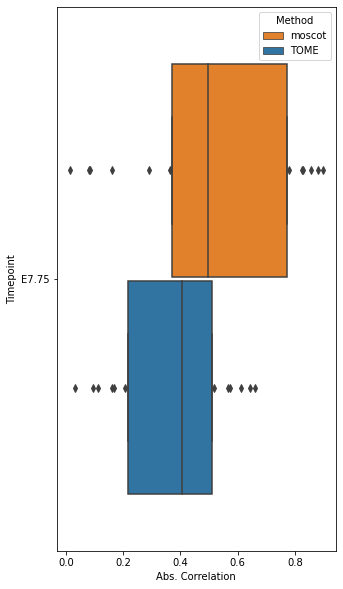

In [20]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 10))
sns.boxplot(data=DF, x="Abs. Correlation", y="Timepoint", hue='Method', showfliers=True,
               showmeans=False,  whis=[100,0], ax=ax, palette=pals)

In [21]:
DF.to_pickle(f'{Path}/Correlations/FHF.npy')